In [1]:
# Import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 
path = '../Data/'

In [2]:
df = pd.read_csv(path+'training.1600000.processed.noemoticon.csv',  header=None, 
                 encoding="ISO-8859-1")

In [3]:
df.shape

(1600000, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


#### Dataset Column Info
- target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- ids: The id of the tweet
- date: the date of the tweet
- flag: The query. If there is no query, then this value is NO_QUERY.
- user: the user that tweeted
- text: the text of the tweet

In [5]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
# Set proper column names
df.rename({0: 'target', 1: 'ids', 2: 'tweet_date', 3: 'flag',
          4: 'user', 5: 'text'}, axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   target      1600000 non-null  int64 
 1   ids         1600000 non-null  int64 
 2   tweet_date  1600000 non-null  object
 3   flag        1600000 non-null  object
 4   user        1600000 non-null  object
 5   text        1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
df.target.value_counts()

0    800000
4    800000
Name: target, dtype: int64

### Pre-processing & Data Cleaning

In [9]:
# import libraries
import re
import nltk
from nltk.corpus import stopwords
# 
# from nltk.tokenize import word_tokenize 
# import stemmer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
# 
# nltk.download('wordnet')
# nltk.download('stopwords')
from wordcloud import WordCloud, ImageColorGenerator
%matplotlib inline

In [10]:
# Create an object of class Stemmers & Lemmatizer
porter = PorterStemmer()
lancaster = LancasterStemmer()
englishStemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

### Testing to Determine Stemmer

In [11]:
word_list = ["friendly", "friendship", "friends", "friendships","need", "boiling",
             "destabilize","misunderstanding", "faith", "destabilizing", "disstable",
             "railroad","screaming","football", "township", "can", "would've"]

In [12]:
for word in word_list:
    print("{0:20}{1:20}{2:20}{3:20}{4:20}".format(word,
                                          porter.stem(word),
                                          englishStemmer.stem(word),
                                          lancaster.stem(word),      
                                          lemmatizer.lemmatize(word,pos="v")))

friendly            friendli            friend              friend              friendly            
friendship          friendship          friendship          friend              friendship          
friends             friend              friend              friend              friends             
friendships         friendship          friendship          friend              friendships         
need                need                need                nee                 need                
boiling             boil                boil                boil                boil                
destabilize         destabil            destabil            dest                destabilize         
misunderstanding    misunderstand       misunderstand       misunderstand       misunderstand       
faith               faith               faith               fai                 faith               
destabilizing       destabil            destabil            dest                destabilize

#### Select Lancaster Stemmer

In [13]:
# all the stop words minus "not"
stop_words = set(stopwords.words('english')) 
print('before: ' , len(stop_words))
stop_words.remove('not')
stop_words.add('u')
print('after: ' , len(stop_words))

before:  179
after:  179


### Clean Tweet & Apply Lancaster Stemmer

In [14]:
def preprocess(text):
        text = text.lower() # lower case
        # specific
        text = re.sub(r"won\'t", "will not", text)
        text = re.sub(r"can\'t", "can not", text)
        text = re.sub("lol", " laughing out loud ", text)
        text = re.sub("idk", " i do not know ", text)
        text = re.sub("omg", " oh my god ", text)
        text = re.sub(" youll", " you will ", text)
        # general
        text = re.sub(r"n\'t", " not", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'s", " is", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'t", " not", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'m", " am", text)       
        text = re.sub('#\S+ ', '', text) # removing hashtags
        text = re.sub('#\S+', '', text) # removing hashtags at he end
        text = re.sub('http:\S+ ', '', text) # removing web links
        text = re.sub('http:\S+', '', text) # removing web links at the end
        text = re.sub('www.\S+ ', '', text) # removing web links
        text = re.sub('www.\S+', '', text) # removing web links at the end
        text = re.sub('@\S+ ', '', text) # removing @tag
        text = re.sub('@\S+', '', text)  # removing @tag when no space at the end
        text = re.sub('[^a-zA-Z]', ' ', text) # remove all non characters
        text = text.split()
        text = [lancaster.stem(word) for word in text if not word in set(stop_words)]
        return ' '.join(text)

### Testing Function

In [15]:
text = "That's no good http://yfrog.com/667c7j @bellyflops89 lol! 100 followers \
        idk!! a omg!! youll day using www.tweeteradder.com #asot400 \
        Once you add everyone you are on the train or pay would've u @mzlalanab http://yfrog.com/667c7j u u"

preprocess(text)

'good laugh loud follow not know oh god day us ad everyon train pay would'

### Apply text_clean column 

In [16]:
%time df['text_clean'] = df['text'].apply(lambda x: preprocess(x))

CPU times: user 3min 1s, sys: 259 ms, total: 3min 1s
Wall time: 3min 1s


In [17]:
# check for nulls after cleaning
df.isnull().sum()

target        0
ids           0
tweet_date    0
flag          0
user          0
text          0
text_clean    0
dtype: int64

In [18]:
pd.set_option("display.max_colwidth", 0)
df[['target', 'text','text_clean']].sample(10)

,target,text,text_clean
1504933,4,@Televixen You can't call people on facebook lame! You're calling all of our parents lame!,not cal peopl facebook lam cal par lam
1077839,4,"D: - yesterdayilied: nooooooooooooooooooï¿½! thats fucked up, ahaaha im sneak a camera and record it ï¿½we can... http://tumblr.com/xz51wjq4p",yesterdayy noooooooooooooooooo that fuck ahaah im sneak camer record
1367056,4,vou dormir escutando Fuck You em repeat,vou dormir escutando fuck em rep
540193,0,Not off to the best start at poker,not best start pok
1349617,4,@markhoppus the red one.,red on
1112554,4,@wallflour Have been a fan since I found your blog,fan sint found blog
1288845,4,is currently reading the book; 'wizard of oz'.,cur read book wizard oz
167197,0,@jamie_oliver I was off by one year. I really wanted some of Jamies cooking books in ENGLISH!!!! not German.,on year real want jamy cook book engl not germ
1412216,4,Impressive how quick I can make a mess of a room. Wow,impress quick mak mess room wow
123780,0,i'm nervous! my hands are shaking. my dad called me just now and said that me &amp; my family will get injections soon,nerv hand shak dad cal said amp famy get inject soon


In [19]:
# two target values (binary classification)
df.loc[df.target > 0, "target"] = 1

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

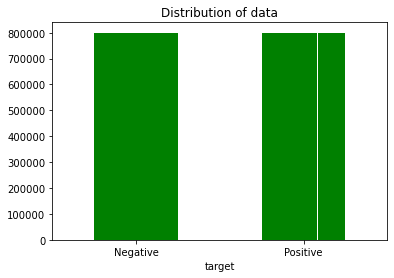

In [20]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', color = 'green', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

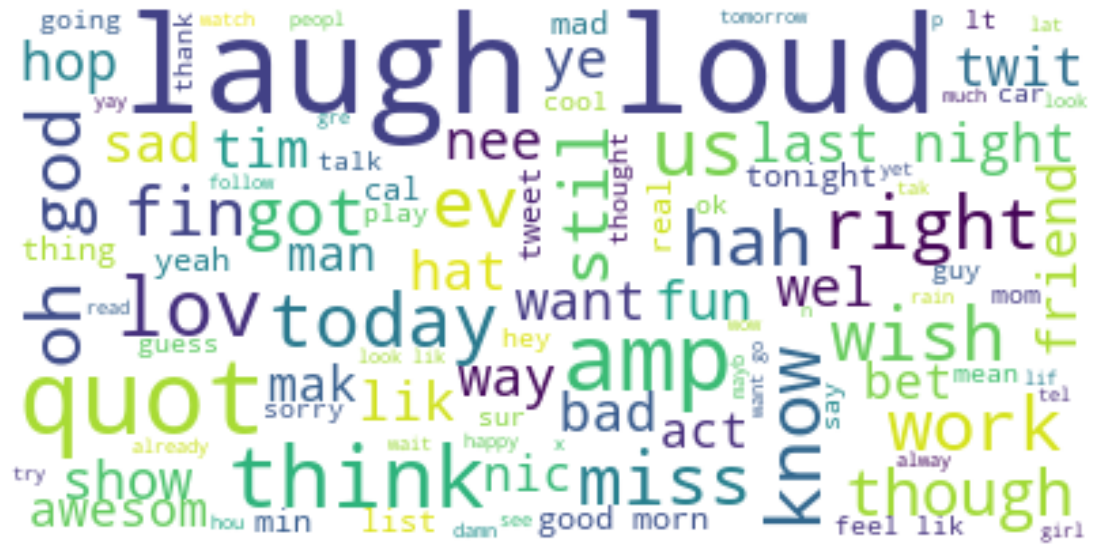

In [21]:
text = " ".join(tweet for tweet in df.text_clean)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=[20,10])
# interpolation="bilinear": This is to make the displayed image appear more smoothly.
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
pd.Series(' '.join(df.text_clean).split()).value_counts()[:10]

not      292036
get      110917
day      108276
good     92504 
work     88161 
lik      84000 
lov      83818 
go       74000 
quot     73139 
today    68686 
dtype: int64

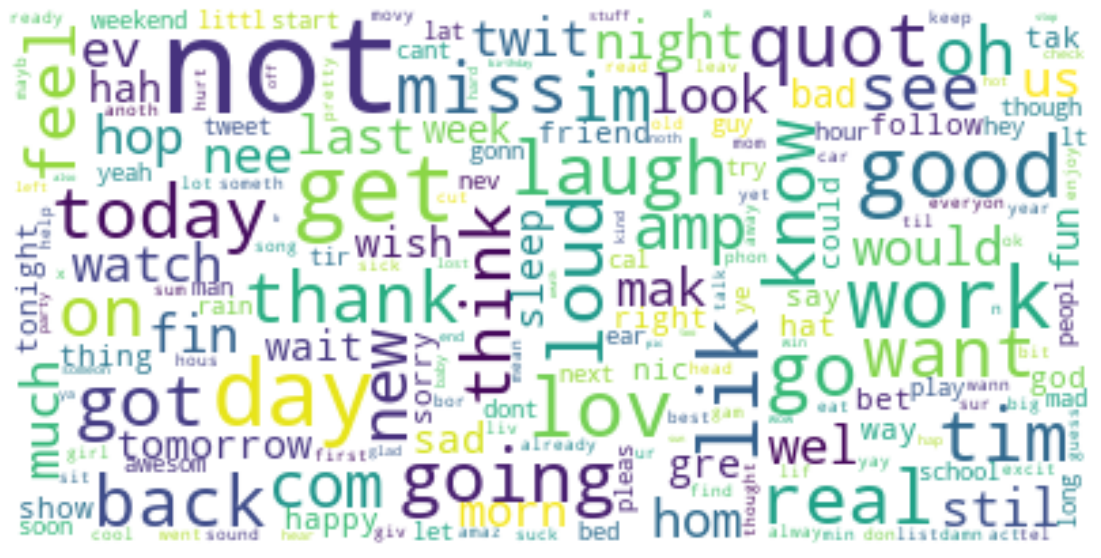

In [23]:
# Word cloud using frequency
words = pd.DataFrame(pd.Series(' '.join(df.text_clean).split()).value_counts())
words.reset_index(inplace=True)
# 
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white")
# 
d = {}
for a, x in words.values:
    d[a] = x
#     
wordcloud.generate_from_frequencies(frequencies=d, max_font_size=50)
plt.figure(figsize=[20,10])
# interpolation="bilinear": This is to make the displayed image appear more smoothly.
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [24]:
# Clean Dataset to Disk
%time df.to_csv('../Data/df_cleaned.csv', index=False)

CPU times: user 6.57 s, sys: 309 ms, total: 6.88 s
Wall time: 6.89 s
